In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
%matplotlib notebook
os.chdir('/Users/apple/Desktop/group/data');
plt.rcParams['figure.figsize'] = (12, 12) # set default size of plots
plt.rcParams.update({'font.size': 18}) # set default font size

Y0=1
RingCull=3000
MaxTime=1000

In [2]:
FarmData2001=pd.read_csv('FarmData2001.txt', 
                       names = ["County Number", "Parish Number", "Holding Number", "X Coordinate", "Y Coordinate", "Farm Area", 
                                "Number of Cattle", "Number of Pigs", "Number of Sheep", "Number of Goats", "Number of other Animals"], delim_whitespace=True)
CumbData = FarmData2001[FarmData2001['County Number'] == 8]
CumbData = CumbData.reset_index(drop=True)
CumbData=np.absolute(CumbData)
x=np.array(CumbData['X Coordinate'])
y=np.array(CumbData['Y Coordinate'])
Cows=np.array(CumbData['Number of Cattle'])
Sheep=np.array(CumbData['Number of Sheep'])
XRange=np.max(x)-np.min(x)+1;
YRange=np.max(y)-np.min(y)+1;
N=x.shape[0]
Y0=1;
Status=np.zeros((N,1)); 
Status[0:Y0]=1;
Suscept=Sheep+10.5*Cows; Transmiss=5.1*10**(-7)*Sheep + 7.7*10**(-7)*Cows;

In [4]:
def WhichGrid(x,y,XRange,YRange,XNum,YNum):
    G=np.floor(x*XNum/XRange)*YNum+np.floor(y*YNum/YRange)+1
    return G

In [5]:
grid=WhichGrid(x-min(x),y-min(y),XRange,YRange,10,10)

In [6]:
index=np.argsort(grid,axis=0)

In [7]:
x=x[index]
y=y[index]
Status=Status[index]
grid=grid[index]

In [8]:
Xgrid=np.zeros((int(np.max(grid)),1))
Ygrid=np.zeros((int(np.max(grid)),1))
Num=np.zeros((int(np.max(grid)),1))
first_in_grid=np.zeros((int(np.max(grid)),1))
last_in_grid=np.zeros((int(np.max(grid)),1))
Max_Sus_grid=np.zeros((int(np.max(grid)),1))

In [9]:
for i in range(int(np.max(grid))):
    Xgrid[i]=np.floor(i/10.0);
    Ygrid[i]=i%10;
    m=[j for j in range(len(grid)) if grid[j]==(i+1)];
    Num[i]=len(m)
    if Num[i]>0:
        first_in_grid[i]=np.min(m)
        last_in_grid[i]=np.max(m)
        Max_Sus_grid[i]=np.max(Suscept[m])
    else:
        first_in_grid[i]=0
        last_in_grid[i]=-1
        Max_Sus_grid[i]=0

In [10]:
def Kernel(Dist2):
    Dist2=[x*(20**2+20**2)/(XRange**2+YRange**2) for x in Dist2]
    P=[-9.2123*10**(-5),9.5628*10**(-4),3.3966*10**(-3),-3.3687*10**(-2),-1.30519*10**(-1),-0.609262,-3.231772];
    K=np.array(np.exp(np.polyval(P,Dist2)))
    index1=[i for i in range(len(Dist2)) if Dist2[i]<0.0138]
    index2=[i for i in range(len(Dist2)) if Dist2[i]>60*60]
    K[index1]=0.3093
    K[index2]=0
    return K

In [11]:
MaxRate=np.zeros((int(np.max(grid)),int(np.max(grid))))
for i in range(int(np.max(grid))):
    for j in range(int(np.max(grid))):
        if (i==j) or (Num[i]==0) or (Num[j]==0):
            MaxRate[i,j]=float('inf')
        else:
            # not use size
            Dist2=(XRange*np.max([0,abs(Xgrid[i]-Xgrid[j])-1])/10.0)**2+(YRange*np.max([0,abs(Ygrid[i]-Ygrid[j])-1])/10.0)**2
            MaxRate[i,j]=Max_Sus_grid[j]*Kernel([Dist2])

In [12]:
def Iterate(Status,x,y,Suscept,Transmiss,RingCull,grid,first_in_grid,last_in_grid,Num,MaxRate):
    Event=0*Status
    INF=[i for i in range(len(Status)) if (Status[i]>5) and (Status[i]<12)]
    NI=len(INF)
    IGrids=grid[INF]
    for i in range(NI):
        INFi=INF[i]
        MaxProb=1-np.exp(-Transmiss[INFi]*np.multiply(np.transpose(Num),MaxRate[int(IGrids[i]-1),:]))
        Rand1=np.random.uniform(0,1,(1,int(max(grid))))
        m=[i for i in range(len(MaxProb[0])) if (MaxProb[0][i]>Rand1[0][i])]
        for n in range(len(m)):
            s=1
            M=m[n]
            PAB=1-np.exp(-Transmiss[INFi]*MaxRate[int(IGrids[0]-1),M])
            if PAB==1:
                ind=np.arange(first_in_grid[M],last_in_grid[M]+1,1)
                ind=map(int,ind)
                Q=1-np.exp(-Transmiss[INFi]*np.multiply(Suscept[ind],Kernel((x[INFi]-x[ind])**2+(y[INFi]-y[ind])**2)))
                Rand2=np.random.uniform(0,1,Q.shape)
                index=[i for i in range(len(Q)) if (Rand2[i]<Q[i]) and (Status[ind[i]]==0)]
                Event[np.array(ind)[index]]=1
            else:
                for j in range(Num[M]):
                    ind=first_in_grid[M]+j-1
                    ind=map(int,ind)
                    P=1-s*np.power((1-PAB),Num[M]+1-j)
                    R=np.random.uniform(0,1,1)
                    if (P==0):
                        s=0
                        if (Status[ind]==0):
                            Event[ind]=1
                    elif (R<PAB/P):
                        s=0
                        Q=1-np.exp(-Transmiss[INFi]*np.multiply(Suscept[ind],Kernel((x[INFi]-x[ind])**2+(y[INFi]-y[ind])**2)))
                        if (R<Q/P) and (Status[ind]==0):
                            Event[ind]=1
    m=[i for i in range(len(Status)) if Status[i]>0]
    Status[m]=Status[m]+1
    Status=Status+Event
    
    m=[i for i in range(len(Status)) if Status[i]==13]
    for i in range(len(m)):
        Status[m[i]]=-1
        D=np.power(x[m[i]]-x,2)+np.power(y[m[i]]-y,2)
        n=[i for i in range(len(x)) if D[i]<RingCull**2]
        Status[n]=-1
    return Status

<IPython.core.display.Javascript object>


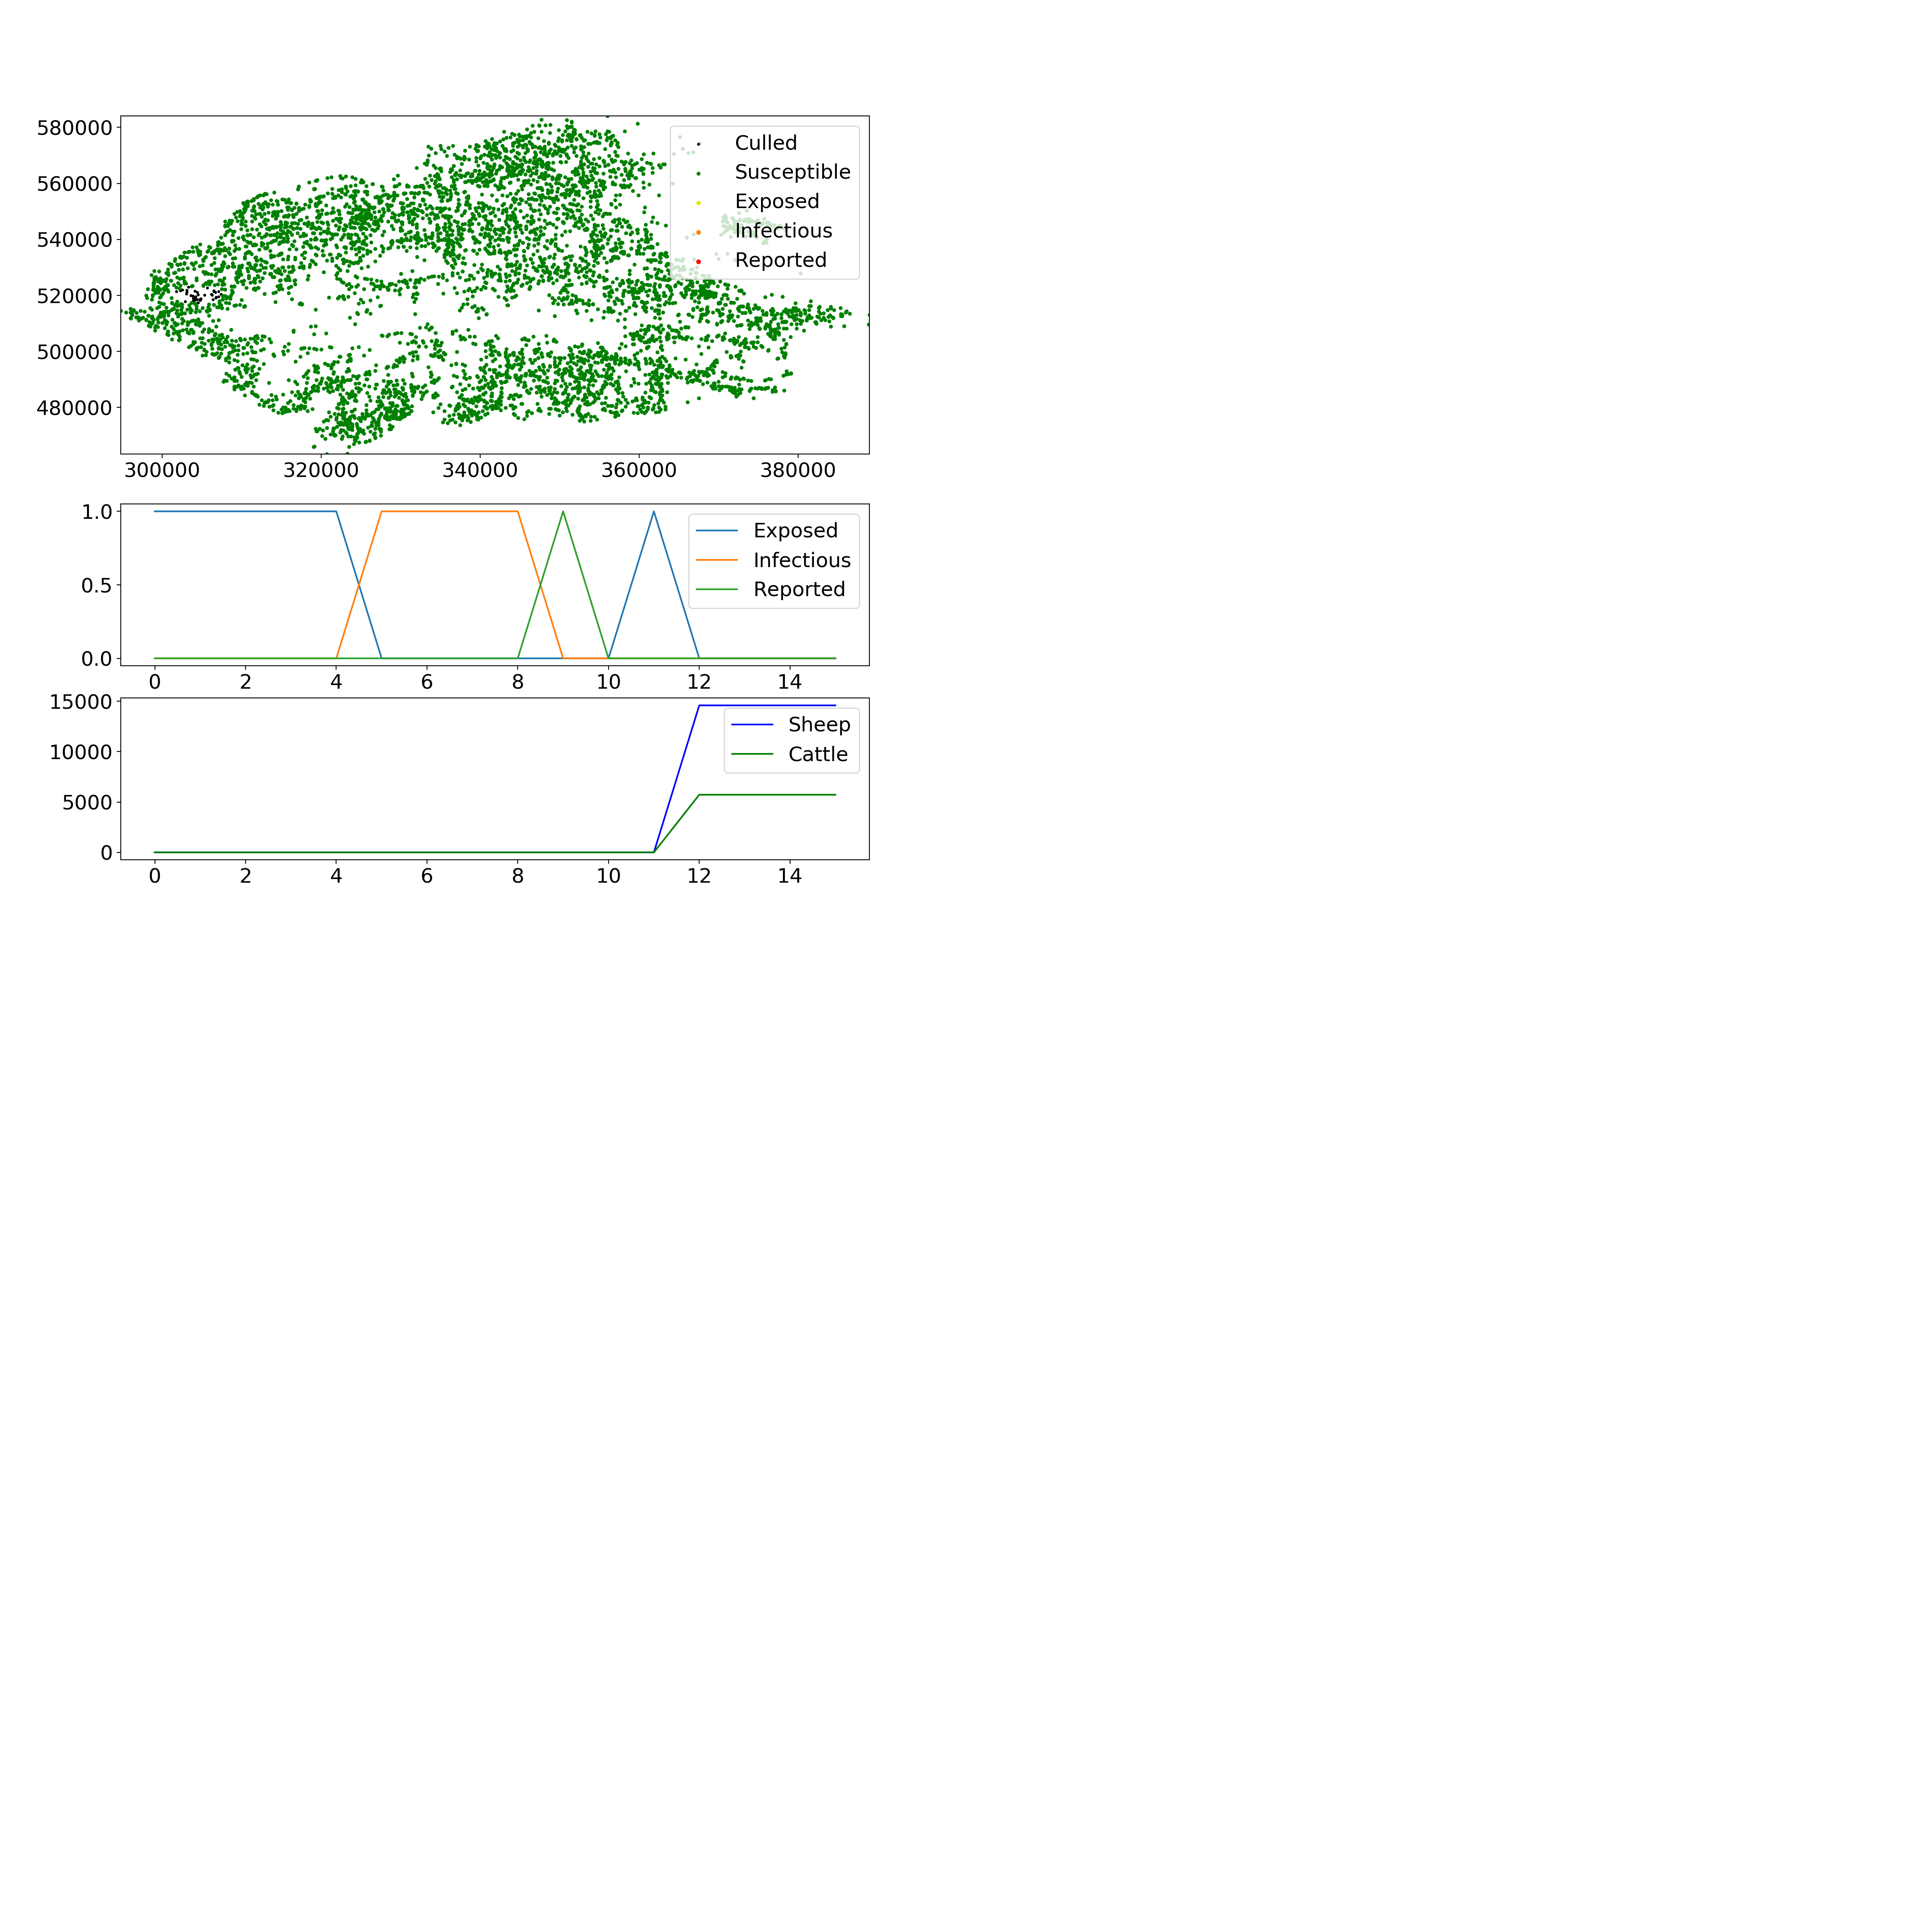

/Users/apple/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


In [13]:
t=[0]
S=[len([i for i in range(len(Status)) if Status[i]==0])]
E=[len([i for i in range(len(Status)) if (Status[i]>0) and (Status[i]<=5)])]
I=[len([i for i in range(len(Status)) if (Status[i]>5) and (Status[i]<=9)])]
R=[len([i for i in range(len(Status)) if Status[i]==10])]
R2=[len([i for i in range(len(Status)) if Status[i]>9])]
CullSheep=[0]
CullCattle=[0]
IterateFlag=1

fig = plt.figure()
ax = fig.add_subplot(211)
ax1 = fig.add_subplot(413)
ax2 = fig.add_subplot(414)
plt.ion
fig.show()
fig.canvas.draw()

while (t[-1]<MaxTime) and (IterateFlag):
    Status=Iterate(Status,x,y,Suscept,Transmiss,RingCull,grid,first_in_grid,last_in_grid,Num,MaxRate)
    Sus=[i for i in range(len(Status)) if Status[i]==0]
    Exp=[i for i in range(len(Status)) if (Status[i]>0) and (Status[i]<=5)]
    Inf=[i for i in range(len(Status)) if (Status[i]>5) and (Status[i]<=9)]
    Rep=[i for i in range(len(Status)) if Status[i]==10]
    Rep2=[i for i in range(len(Status)) if Status[i]>9]
    Culled=[i for i in range(len(Status)) if Status[i]<0]
    S.append(len(Sus))
    E.append(len(Exp))
    I.append(len(Inf))
    R.append(len(Rep))
    R2.append(len(Rep2))
    CullSheep.append(np.sum(Sheep[Culled]))
    CullCattle.append(np.sum(Cows[Culled]))
    t.append(t[-1]+1)
    
    if t[-1]>5:
        if E[-4]+I[-4]+R2[-4]==0:
            IterateFlag=0
    
  
    ax.clear()
    ax1.clear()
    ax2.clear()
    
    ax.scatter(x[Culled],y[Culled], c='k', marker='.', s=10, label='Culled')
    ax.scatter(x[Sus],y[Sus], c='g', marker='o', s=6, label='Susceptible')
    ax.scatter(x[Exp],y[Exp], c=[0.9, 0.9, 0], marker='o', s=8, label='Exposed')
    ax.scatter(x[Inf],y[Inf], c=[1, 0.5, 0], marker='o', s=10, label='Infectious')
    ax.scatter(x[Rep],y[Rep], c='r', marker='o', s=10, label='Reported')
    ax.axis([min(x), max(x), min(y), max(y)])
    ax.legend()
    
    ax1.plot(t,E,label='Exposed')
    ax1.plot(t,I,label='Infectious')
    ax1.plot(t,R,label='Reported')
    ax1.legend()
    
    
    ax2.plot(t,CullSheep,'-b',label='Sheep')
    ax2.plot(t,CullCattle,'-g',label='Cattle');
    ax2.legend()
    fig.canvas.draw()  
            

In [14]:
S

[6214,
 6214,
 6214,
 6214,
 6214,
 6214,
 6214,
 6214,
 6214,
 6214,
 6214,
 6213,
 6175,
 6175,
 6175,
 6175]

In [15]:
I

[0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]

In [16]:
E

[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

In [17]:
R

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

In [18]:
R2

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]

In [19]:
CullSheep

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14586, 14586, 14586, 14586]

In [20]:
CullCattle

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5721, 5721, 5721, 5721]

In [21]:
t

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]